In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.linalg import svd
import numpy as np
import matplotlib.patches as mpatches
from wordcloud import WordCloud
import plotly.express as px
import re

In [127]:
# Load the dataset
file_path = "./European_data_2000.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Convert columns to appropriate data types
df["releaseYear"] = df["releaseYear"].astype("Int64")
df["runtimeMinutes"] = df["runtimeMinutes"].astype("Int64")
df["numberOfVotes"] = df["numberOfVotes"].astype("Int64")

print(df)

        titleId                                imdbUrl  \
0     tt3042384  https://www.imdb.com/title/tt3042384/   
1     tt2486278  https://www.imdb.com/title/tt2486278/   
2     tt1361313  https://www.imdb.com/title/tt1361313/   
3     tt0222124  https://www.imdb.com/title/tt0222124/   
4     tt0421229  https://www.imdb.com/title/tt0421229/   
...         ...                                    ...   
1995  tt0003930  https://www.imdb.com/title/tt0003930/   
1996  tt1638002  https://www.imdb.com/title/tt1638002/   
1997  tt0081738  https://www.imdb.com/title/tt0081738/   
1998  tt0033627  https://www.imdb.com/title/tt0033627/   
1999  tt0063135  https://www.imdb.com/title/tt0063135/   

                                          originalTitle titleType  \
0                                                   Ida     movie   
1                                            Blood Shed     movie   
2                                         The Extra Man     movie   
3     Se tutte le donne del

In [128]:
print(df.columns.tolist())

['titleId', 'imdbUrl', 'originalTitle', 'titleType', 'releaseYear', 'runtimeMinutes', 'isAdult', 'imdbRating', 'numberOfVotes', 'allCountries', 'mainCountry', 'allLanguages', 'firstLanguage', 'englishTitle', 'topFiveActors', 'directors', 'writers', 'plotShort', 'plotMedium', 'plotLong', 'genres', 'keywords', 'production']


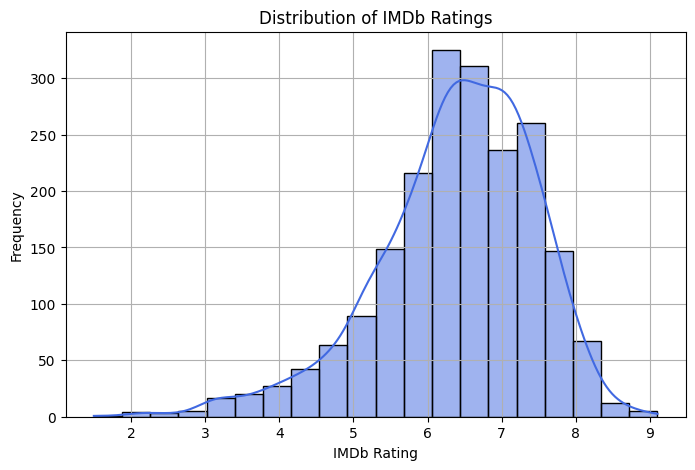

In [129]:
# Visualization: Distribution of IMDb Ratings
plt.figure(figsize=(8, 5))
sns.histplot(df["imdbRating"], bins=20, kde=True, color="royalblue")
plt.title("Distribution of IMDb Ratings")
plt.xlabel("IMDb Rating")
plt.ylabel("Frequency")
plt.grid()
plt.show()

C:\Users\gisle\AppData\Local\Temp\ipykernel_63764\3396268489.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




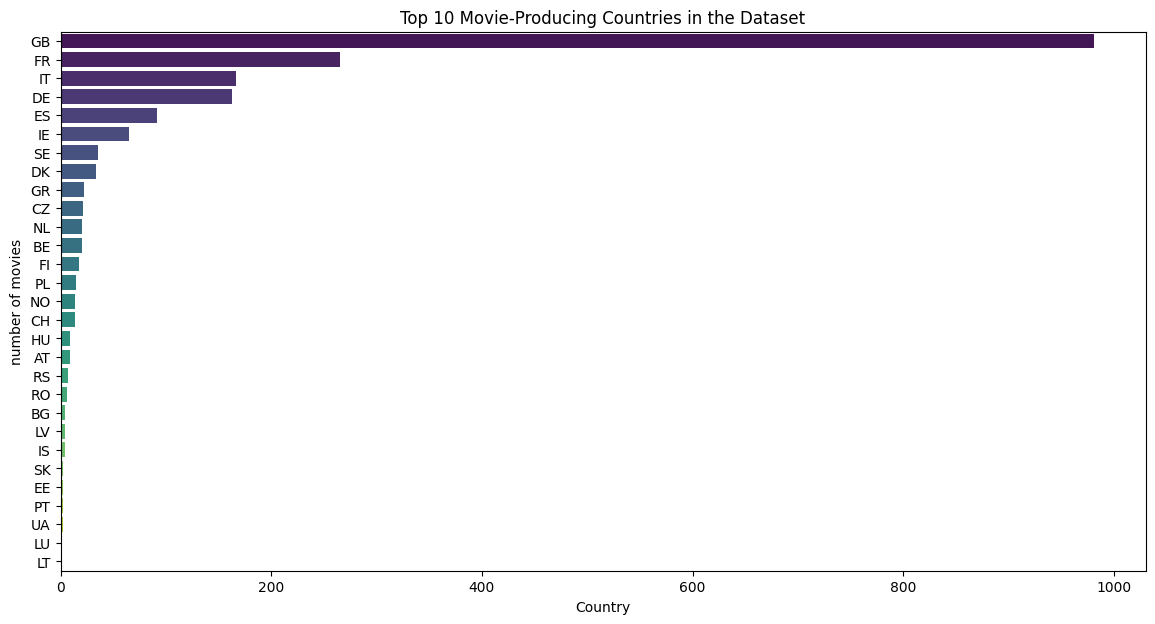

In [130]:
# Visualization: Movie count by country
plt.figure(figsize=(14, 7))
top_countries = df["mainCountry"].value_counts().nlargest(29)
sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")
plt.xlabel("Country")
plt.ylabel("number of movies")
plt.title("Top 10 Movie-Producing Countries in the Dataset")
plt.show()

C:\Users\gisle\AppData\Local\Temp\ipykernel_63764\1833505293.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




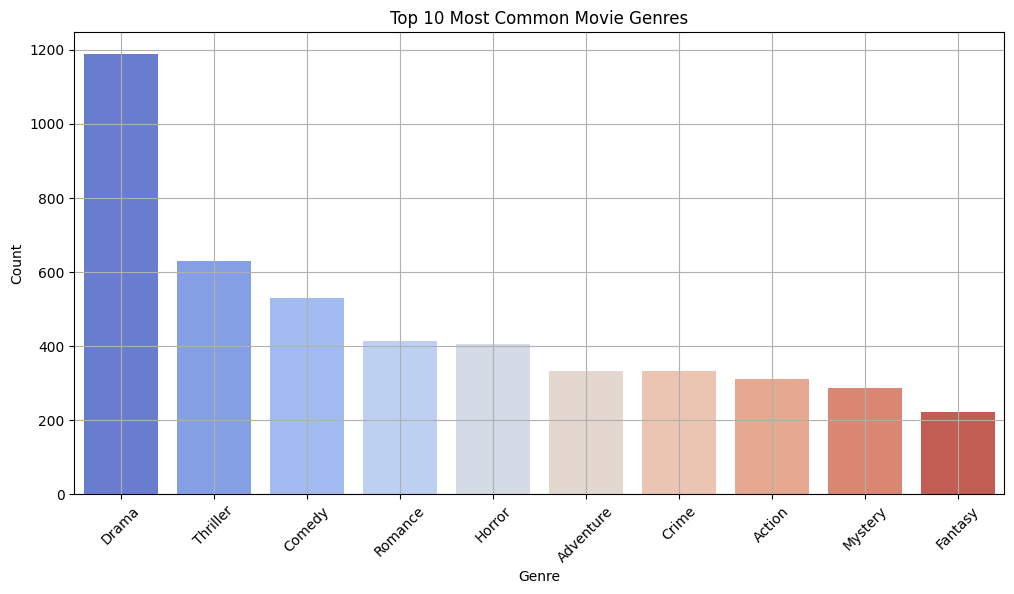

In [131]:
plt.figure(figsize=(12, 6))
all_genres = df["genres"].str.split(", ").explode()
top_genres = all_genres.value_counts().nlargest(10)
sns.barplot(x=top_genres.index, y=top_genres.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Most Common Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.grid()
plt.show()

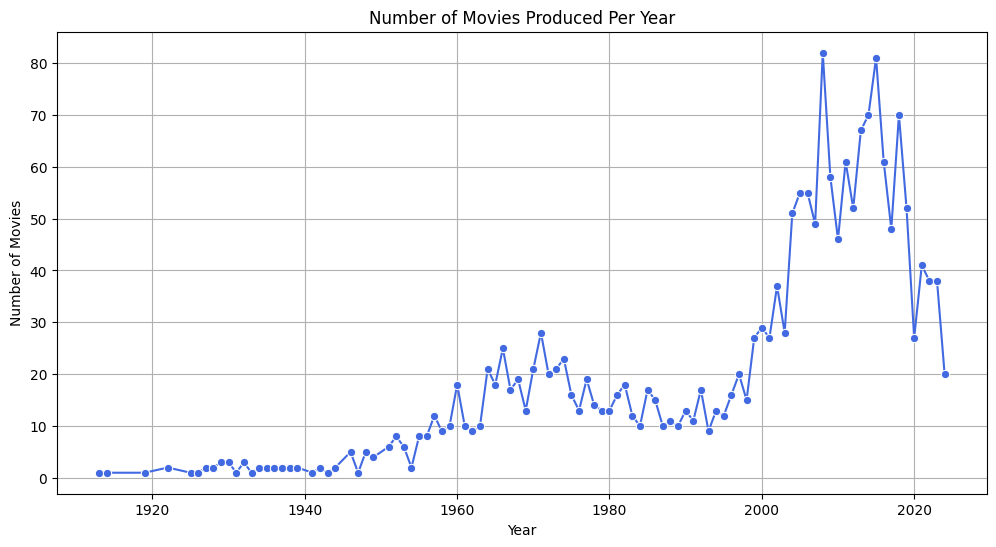

In [132]:
plt.figure(figsize=(12, 6))
movies_per_year = df["releaseYear"].value_counts().sort_index()
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values, marker="o", color="royalblue")
plt.title("Number of Movies Produced Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.grid()
plt.show()

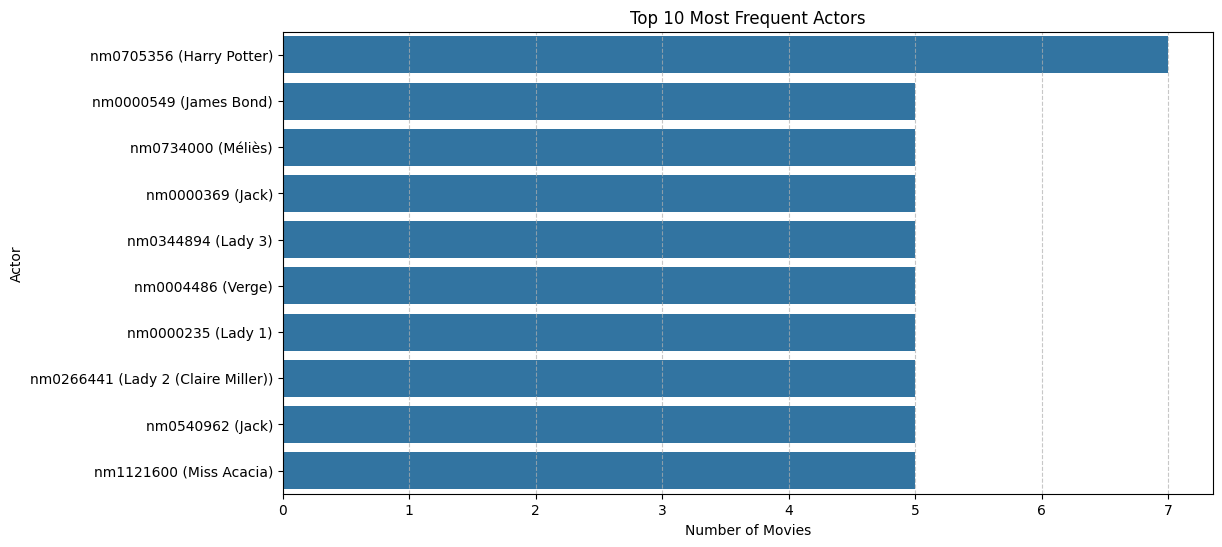

In [133]:
plt.figure(figsize=(12, 6))
all_actors = df["topFiveActors"].str.split(", ").explode()
top_actors = all_actors.value_counts().nlargest(10)
sns.barplot(x=top_actors.values, y=top_actors.index)
plt.title("Top 10 Most Frequent Actors")
plt.xlabel("Number of Movies")
plt.ylabel("Actor")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

In [148]:
# Load the directors mapping dataset
file_path = "./DirectorsNames.csv"  # Ensure the file path is correct
df_directors_mapping = pd.read_csv(file_path, delimiter=";")

# Step 1: Explode the directors column (some movies have multiple directors)
df_exploded = df.copy()
df_exploded["directors"] = df_exploded["directors"].str.split(", ")
df_exploded = df_exploded.explode("directors")

# Strip whitespace in director IDs for clean mapping
df_exploded["directors"] = df_exploded["directors"].str.strip()
df_directors_mapping["Id Person"] = df_directors_mapping["Id Person"].astype(str)

# Map "Id Person" to director names
df_exploded["directors"] = df_exploded["directors"].map(
    df_directors_mapping.set_index("Id Person")["Name"]
)

# Drop rows where mapping failed (i.e., missing director names)
df_exploded = df_exploded.dropna(subset=["directors"])

# **Filter for movies released in the last 30 years**
current_year = 2024
year_threshold = current_year - 25  # 1994
df_exploded = df_exploded[df_exploded["releaseYear"] >= year_threshold]

C:\Users\gisle\AppData\Local\Temp\ipykernel_63764\3220237007.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




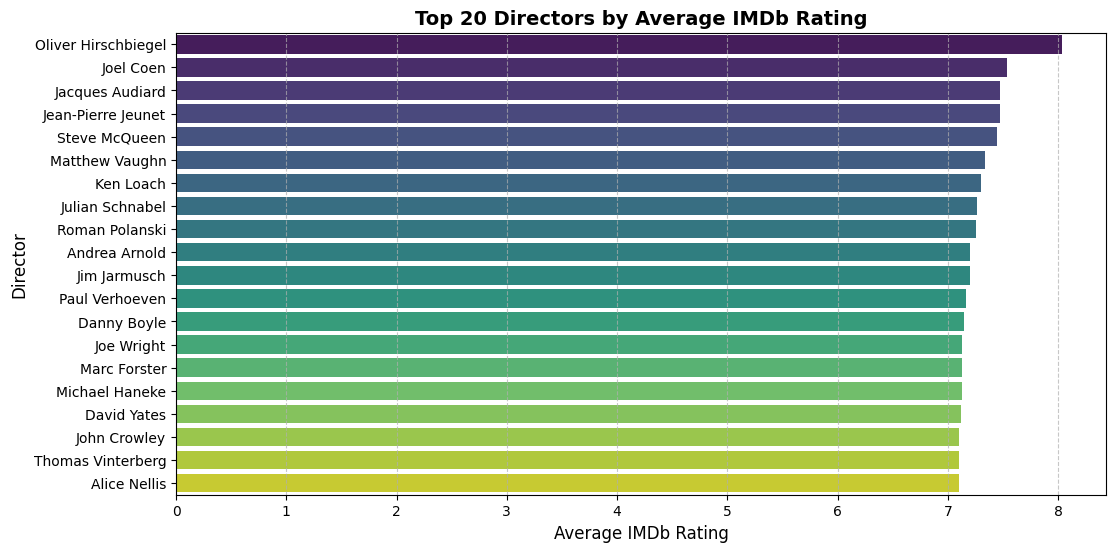

In [149]:
# Step 2: Compute average IMDb rating per director
director_avg_rating = df_exploded.groupby("directors")["imdbRating"].agg(["mean", "count"]).reset_index()
director_avg_rating.columns = ["Director", "Average IMDb Rating", "Movie Count"]

# Step 3: Filter for directors with at least 3 movies (optional, to remove outliers)
min_movies = 3
director_avg_rating = director_avg_rating[director_avg_rating["Movie Count"] >= min_movies]

# Step 4: Select the top 20 directors by highest average IMDb rating
top_20_directors = director_avg_rating.sort_values(by="Average IMDb Rating", ascending=False).head(20)

# Step 5: Plot as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(y="Director", x="Average IMDb Rating", data=top_20_directors, palette="viridis")

# Add titles and labels
plt.title("Top 20 Directors by Average IMDb Rating", fontsize=14, fontweight="bold")
plt.xlabel("Average IMDb Rating", fontsize=12)
plt.ylabel("Director", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

### Possibilities for network data analysis
actors and writers/directors and see hidden patterns (create a network where the vertices are the people and the edges the movies or a bipartite network with actors on one side and directors on the other)
countries and genre mapped (create a map of the world and when you hover over the country genres will pop up)
runtime and the rating if it goes up or down 


In [136]:
df_copy = df.copy()

# Combine all keywords into a single string
# Assuming the 'keywords' column contains comma-separated keywords for each movie
all_keywords = df['keywords'].dropna().tolist()

# Split the keywords on comma and flatten the list
keywords_list = [keyword.strip() for entry in all_keywords for keyword in entry.split(',')]

In [137]:
# Select only the relevant columns
df_cleaned = df_copy[["releaseYear", "runtimeMinutes", "isAdult", "imdbRating", "numberOfVotes"]]

# Convert categorical/binary columns
df_cleaned["isAdult"] = df_cleaned["isAdult"].astype(int)  # Ensure it's binary (0/1)

# Check to see if there are any missing values
print(df_cleaned.isnull().sum())

# We'll keep the dropping of null values just in case
df_cleaned = df_cleaned.dropna()

releaseYear       0
runtimeMinutes    0
isAdult           0
imdbRating        0
numberOfVotes     0
dtype: int64


C:\Users\gisle\AppData\Local\Temp\ipykernel_63764\873564718.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [138]:
# Remove outliers 
df_cleaned = df_cleaned[df_cleaned.numberOfVotes <= 1144494]

# 5 Max values of numberOfVotes
max_votes = df_cleaned["numberOfVotes"].nlargest(5)

print("Max value of numberOfVotes:", max_votes)

Max value of numberOfVotes: 1806    1144494
1383     976358
1484     957603
1065     945171
1198     899582
Name: numberOfVotes, dtype: Int64


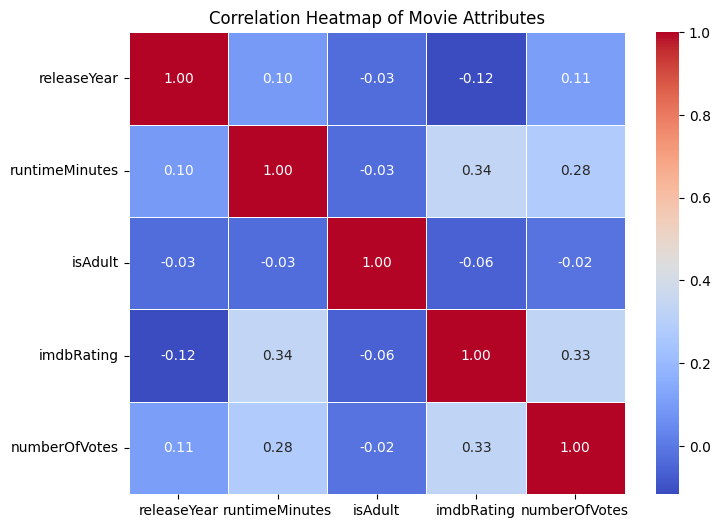

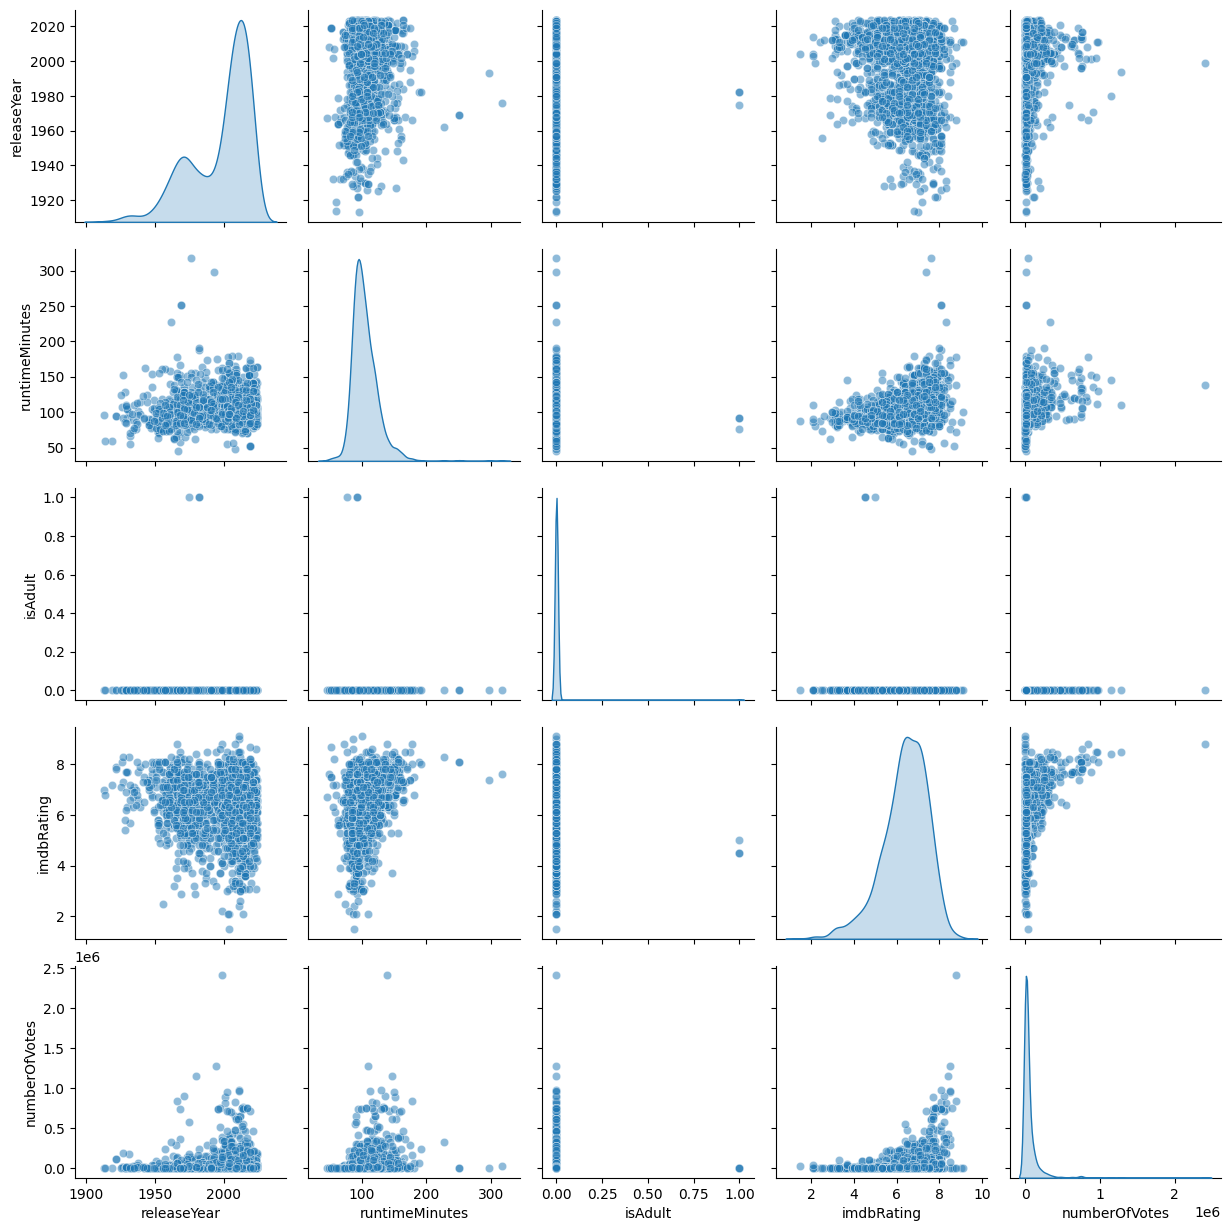

In [151]:
# Ensure correct data types
df["isAdult"] = df["isAdult"].astype(int)  # Ensure binary (0/1)

# Select only relevant columns
df_cleaned = df[["releaseYear", "runtimeMinutes", "isAdult", "imdbRating", "numberOfVotes"]]

# Drop missing values
df_cleaned = df_cleaned.dropna()

# Generate correlation matrix
correlation_matrix = df_cleaned.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Movie Attributes")
plt.show()

# Pairplot to visualize pairwise relationships
sns.pairplot(df_cleaned, diag_kind="kde", plot_kws={'alpha':0.5})
plt.show()

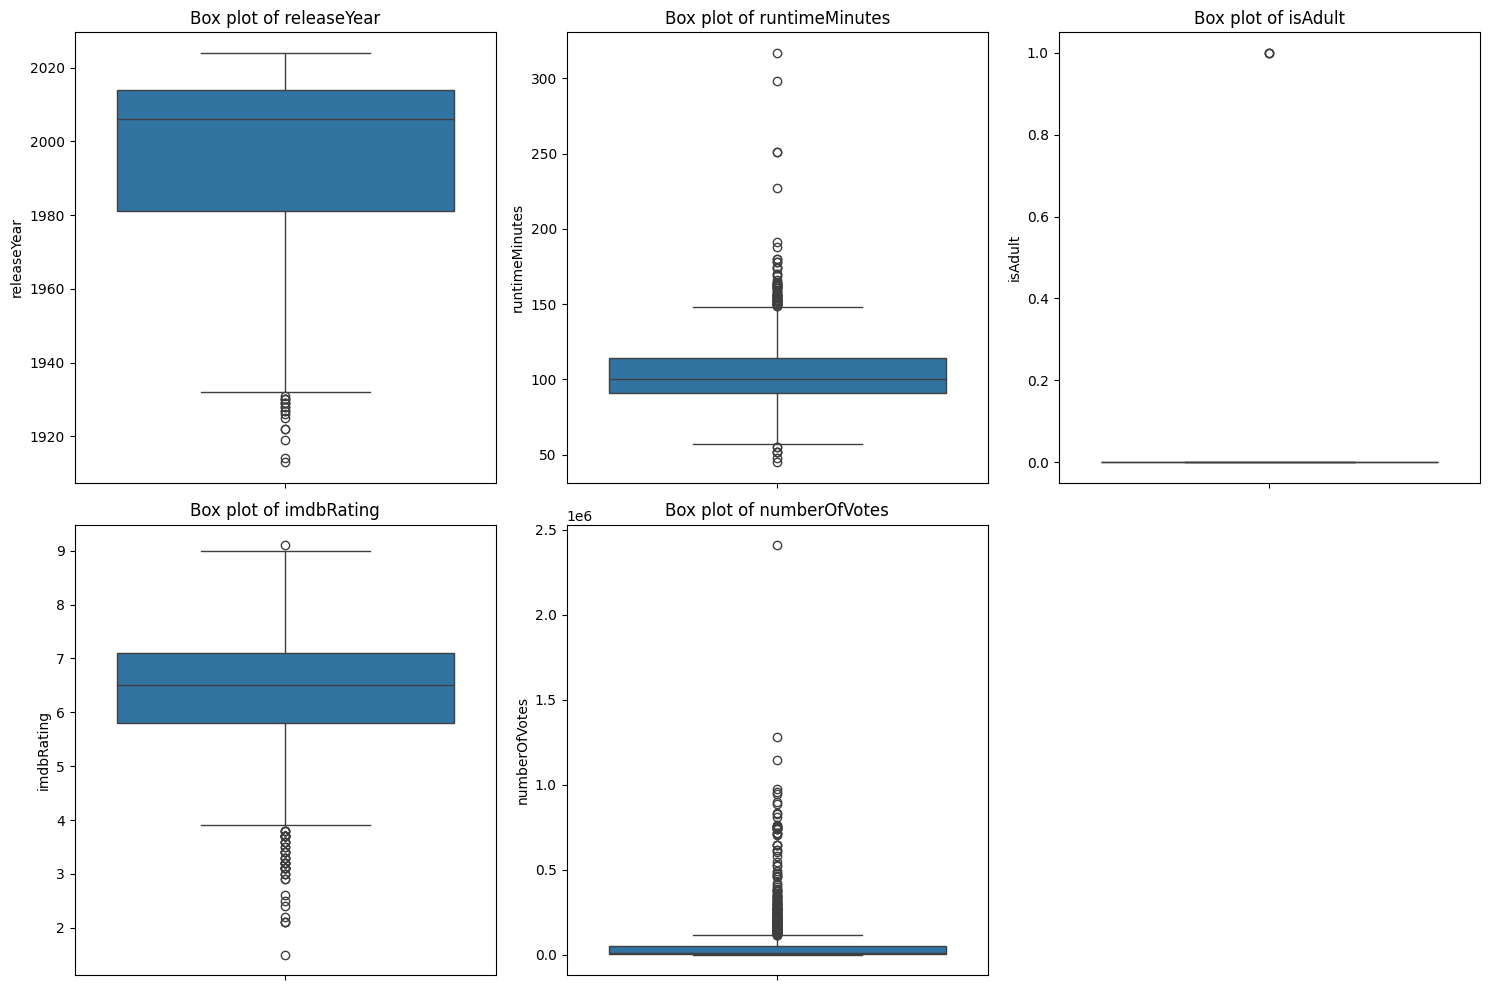

In [139]:
# Plot box plots for each numerical column to visualize outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_cleaned.columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, y=column)
    plt.title(f'Box plot of {column}')
    plt.tight_layout()

plt.show()

In [140]:
# Remove outliers

# numberOfVotes has a massive outlier
df_cleaned = df_cleaned[df_cleaned.numberOfVotes <= 2.5 * 1e6]

In [141]:
# Standardize the data using the StandardScaler import, mathematically this is fairly simple, as it involves Z scoring the data
# with Z = (X - myu) / sigma. This forms the basis of a normal distribution.
scaler = StandardScaler()
# fit calculates the mean and standard deviation of each attribute and transform applies the Z score formula to each attribute.
df_standardized = scaler.fit_transform(df_cleaned)

# Let's see how it looks like now:
print(df_standardized)

[[ 0.71017771 -1.09009959 -0.03877834  0.95166555  0.080061  ]
 [ 0.71017771 -0.25924234 -0.03877834 -3.07658464 -0.45091049]
 [ 0.57257733  0.18062327 -0.03877834 -0.54721824 -0.40895058]
 ...
 [-0.80342641 -0.99235168 -0.03877834 -0.26617753 -0.39227544]
 [-2.59223127  0.91373261 -0.03877834  0.85798531 -0.38715881]
 [-1.3538279  -0.4058642  -0.03877834 -1.48402061 -0.42802167]]


In [142]:
# All the values above show how many standard deviations away from the mean the data is. Notice how there's one value that is 4.94
# standard deviations away from the mean. This is an outlier that we should take into account when we do PCA.

# Another thing to note is that by standardizing the data, we don't need to do
# Y = df_standardized - np.mean(df_standardized, axis=0) anymore because standardizing already transforms the attribute so that the mean is 0.

# Let's finally perform PCA via Single Value Decomposition svd:
U, S, Vt = svd(df_standardized, full_matrices=False)

# Compute variance, squared of each sigma s explained by principal components
# For example: if S is [3, 2, 1] then S * S is [9, 4, 1] and (S * S).sum() is 9 + 4 + 1 = 14.
# rho is [9/14, 4/14, 1/14] = [0.64, 0.29, 0.07] where we get the variance explained by each principal component!
rho = (S * S) / (S * S).sum()

# Let's see how much variance is explained by the first 3 principal components:
print("The first principal component explains", rho[0] * 100, "% of the variance.")
print("The second principal component explains", rho[1] * 100, "% of the variance.")
print("The third principal component explains", rho[2] * 100, "% of the variance.")

The first principal component explains 33.23297158658339 % of the variance.
The second principal component explains 21.54800246573942 % of the variance.
The third principal component explains 19.90320008874231 % of the variance.


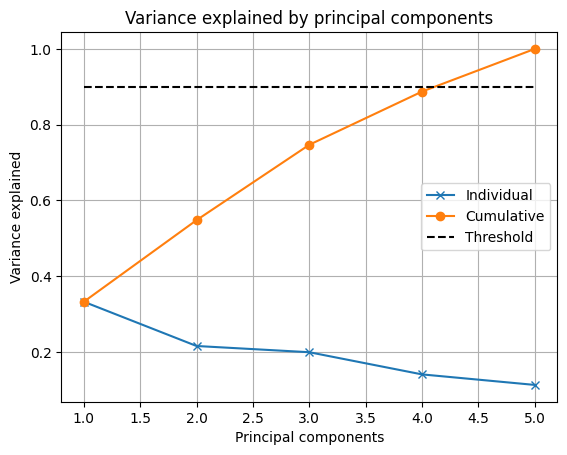

In [143]:
# We can see that the first three principle components are ordered from highest to lowest variance explained.
# Usually we want to define a threshold, which in our case will be 90% of the variance explained.

threshold = 0.9

# Let's try to visualize this better via plots:
plt.figure()
# First plot shows the variance explained by each principal component
plt.plot(range(1, len(rho) + 1), rho, "x-")
# Second will show the cumulative variance explained by the principal components
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
# Let's now add the threshold
plt.plot([1, len(rho)], [threshold, threshold], "k--")
# Add a title
plt.title("Variance explained by principal components")
# Label the axis
plt.xlabel("Principal components")
plt.ylabel("Variance explained")
# Add legend and grid as visual aid
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()

Here we can see that the first 3 principle components 

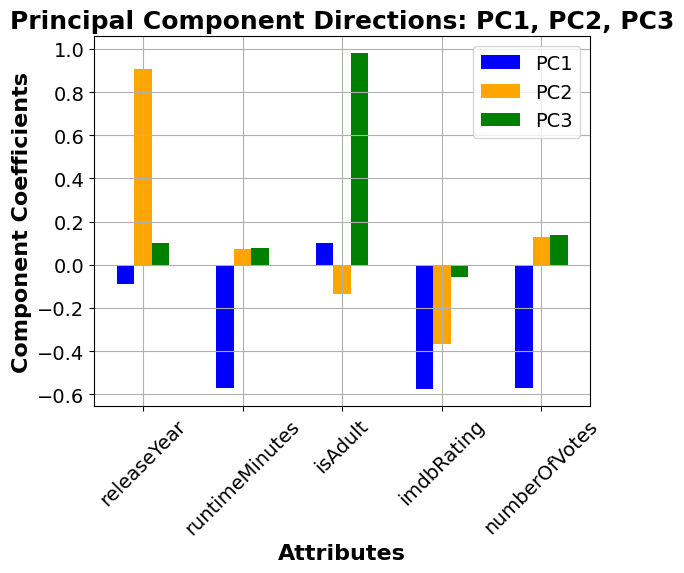

In [144]:
# Remeber earlier, we performed the svd U, S, Vt = svd(df_standardized, full_matrices=False)
# Now we extract the Vt, which is a matrix that contains the vectors defining the principle directions.
principal_directions = Vt.T

# Convert the principal directions to a DataFrame for better formatting
principal_directions_df = pd.DataFrame(principal_directions)

# Transpose the DataFrame to show each principal direction as a column
principal_directions_df = principal_directions_df.T

# Set the components to plot in each subplot
pcs_top = [0, 1, 2]  # First four principal components

# Start by configuring the plot
legendStrs_top = ["PC" + str(e + 1) for e in pcs_top]
colors_top = ["b", "orange", "g"]
bar_width = 0.175
# Below simply creates an array from 0 to the number of principal directions
r = np.arange(principal_directions.shape[0])

# First Subplot: PC1, PC2, PC3, PC4
for i, pc in enumerate(pcs_top):
    # r + i * bar_width calculates the positions of the bars on the x_axis and we plot on the y axis the principal directions of each vector
    plt.bar(r + i * bar_width, principal_directions[:, pc], width=bar_width, color=colors_top[i], label=legendStrs_top[i])
    
# Config the plots more with labels and titles
plt.xticks(r + bar_width, df_cleaned.columns, rotation=45, fontsize=14) 
plt.yticks(fontsize=14)  
plt.xlabel("Attributes", fontsize=16, fontweight='bold')  
plt.ylabel("Component Coefficients", fontsize=16, fontweight='bold') 
plt.title("Principal Component Directions: PC1, PC2, PC3", fontsize=18, fontweight='bold')
plt.legend(fontsize=14)
plt.grid(True)

With 4 principle components, we reach the 90% threshold and here's the results from that:

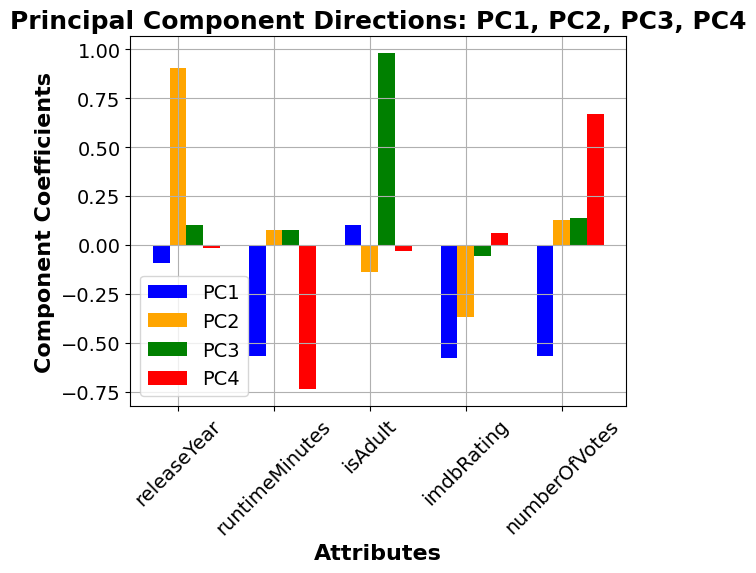

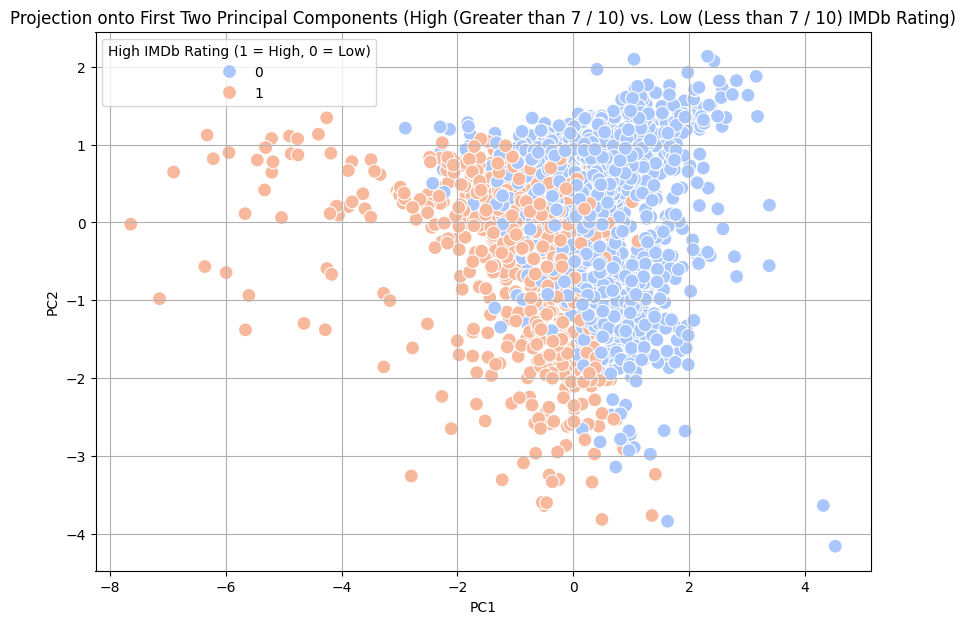

In [145]:
# Project the data onto the principal components
scores = U * S  # Principal component scores

# Convert to DataFrame
projected_df = pd.DataFrame(scores, columns=[f'PC{i+1}' for i in range(scores.shape[1])])

# Define the target variable: high or low IMDb rating
df_cleaned["high_rating"] = (df_cleaned["imdbRating"] >= 7).astype(int)  # 1 = high rating, 0 = low rating

# Add target variable to projected data
projected_df["high_rating"] = df_cleaned["high_rating"].values

# Visualize PC1 vs. PC2
plt.figure(figsize=(10, 7))
sns.scatterplot(x=projected_df['PC1'], y=projected_df['PC2'], hue=projected_df["high_rating"], palette='coolwarm', s=100)
plt.title('Projection onto First Two Principal Components (High (Greater than 7 / 10) vs. Low (Less than 7 / 10) IMDb Rating)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="High IMDb Rating (1 = High, 0 = Low)")
plt.grid(True)
plt.show()

We can observe from this plot that there is a slight distinction between movies rated highly (above 7) and movies rated not highly ( below 7). On the first principle components, we can observe that movies that are on the positive scale of PC1. For PC1 runtimeMinutes has a negative loading for runtimeMinutes, meaning longer runtimes push a movie more towards the negative side of PC1, whilst shorter towards the positive. Additionally, more votes on a movie also has a negative loading so that movies with more votes have a tendency to also have a good rating.

For PC2, the clusters look to be concentrated also on the negative side of Pc2 axis. The release year contributes strongly towards this component and that the higher the release year, i.e the earlier the movie, the more that contributes positively to the PC2 axis. Most highly rated movies don't extent beyond 1 on the PC2 axis, but rather clusters below it and spreads further downwards suggesting older movies seem to be favoured by viewers. This could be as a result of a nostalgia factor.

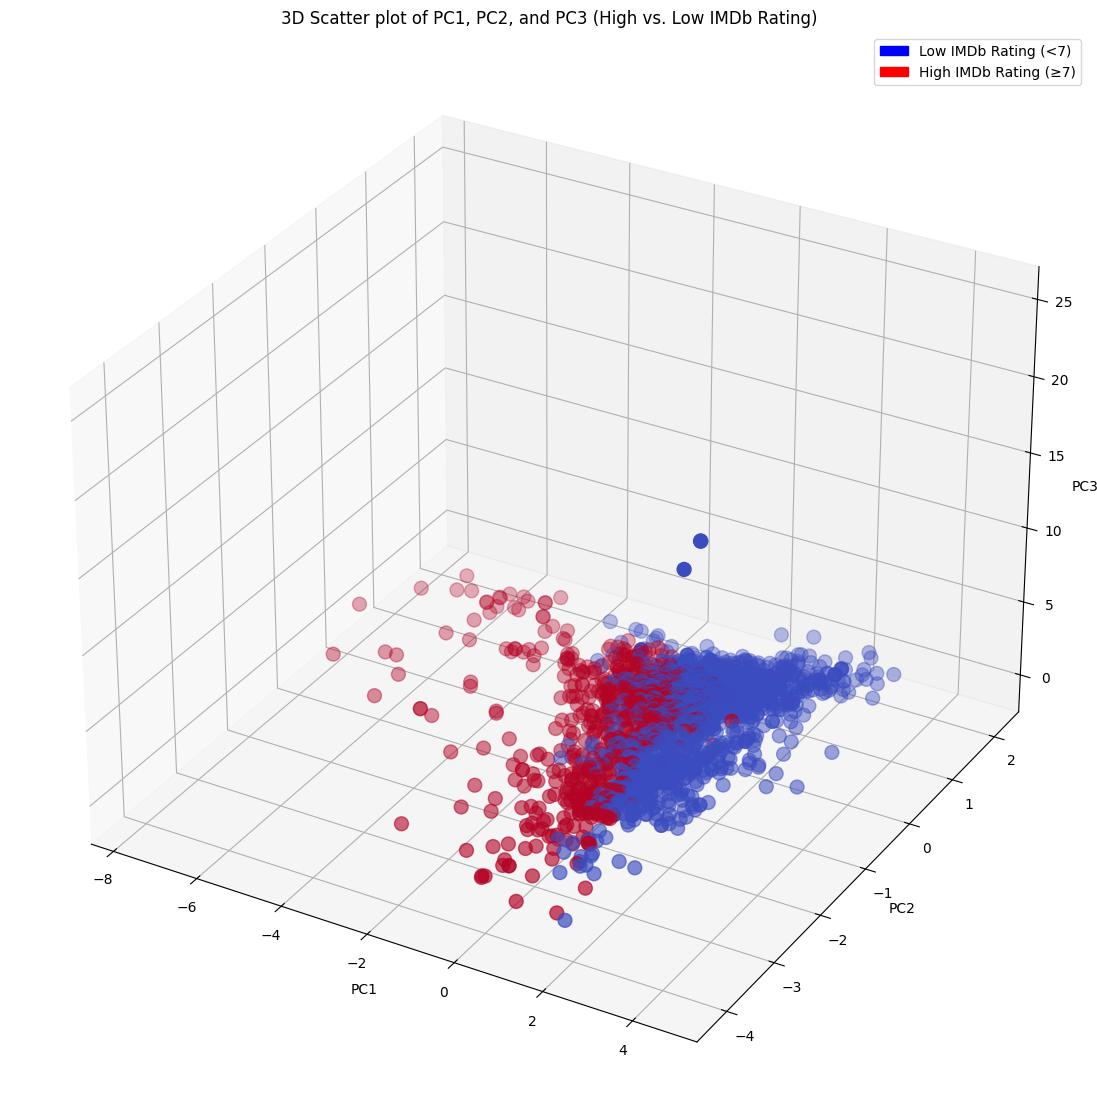

In [152]:
# Create a new figure with interactive 3D projection
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

# 3D Scatter plot of the first three principal components
scatter = ax.scatter(projected_df['PC1'], projected_df['PC2'], projected_df['PC3'], 
                     c=projected_df['high_rating'], cmap='coolwarm', s=100)

# Set axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Set the title of the plot
ax.set_title('3D Scatter plot of PC1, PC2, and PC3 (High vs. Low IMDb Rating)')

# Create custom legend
high_rating_patch = mpatches.Patch(color='red', label='High IMDb Rating (≥7)')
low_rating_patch = mpatches.Patch(color='blue', label='Low IMDb Rating (<7)')

# Add legend to the plot (top right corner)
plt.legend(handles=[low_rating_patch, high_rating_patch], loc='upper right')

# Show the plot
plt.show()

In [147]:
# Create a DataFrame with PC1, PC2, PC3, and high_rating
projected_df['high_rating_label'] = projected_df['high_rating'].map({1: "High IMDb Rating (≥7)", 0: "Low IMDb Rating (<7)"})

# Create interactive 3D scatter plot
fig = px.scatter_3d(projected_df, 
                     x='PC1', y='PC2', z='PC3', 
                     color='high_rating_label', 
                     color_discrete_map={"High IMDb Rating (≥7)": "red", "Low IMDb Rating (<7)": "blue"},
                     title="3D Scatter Plot of PC1, PC2, and PC3 (High vs. Low IMDb Rating)",
                     labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2", "PC3": "Principal Component 3"},
                     opacity=0.8,  # Adjust transparency
                     size_max=3)   # Reduce marker size

fig.show()
